In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install statsmodels

In [ ]:
!pip install backtesting

In [ ]:
!pip install mplfinance

#Importing libraries

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from backtesting.test import SMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from backtesting.lib import SignalStrategy, TrailingStrategy
from sklearn.linear_model import LinearRegression
from backtesting import Backtest
from backtesting.test import GOOG
import warnings
warnings.filterwarnings('ignore')
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, f1_score, recall_score

#Dataset Loading

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mentor ml/goldstock.csv")
# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by=['Date'], inplace=True, ascending=True)

# Drop the 'Unnamed: 0' column if necessary
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)


In [ ]:
print(f"Date range of gold prices available from- {df.index[0]} to {df.index[-1]}")

Date range of gold prices available from- 2014-01-22 00:00:00 to 2024-01-19 00:00:00


In [ ]:
df.describe()

,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,298.824811,97600.769382,299.118187,301.262244,296.417703
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


In [ ]:
df.isna().sum()

Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [ ]:
df1=df['Close']

In [ ]:
df1.head()

Date
2014-01-22    1238.6
2014-01-23    1262.5
2014-01-24    1264.5
2014-01-27    1263.5
2014-01-28    1250.5
Name: Close, dtype: float64

In [ ]:
df1.isna().sum()

0

#EDA

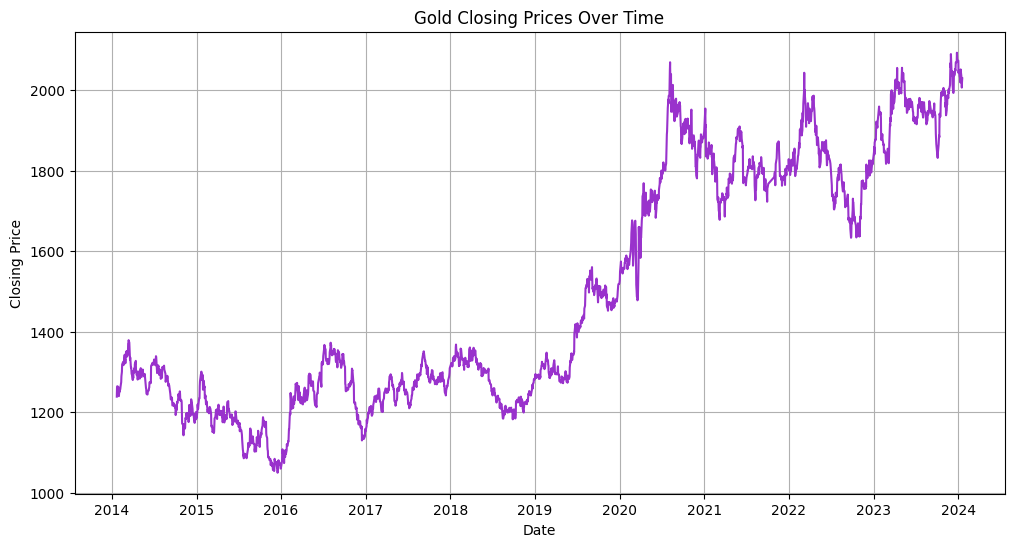

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], color='darkorchid')
plt.title('Gold Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

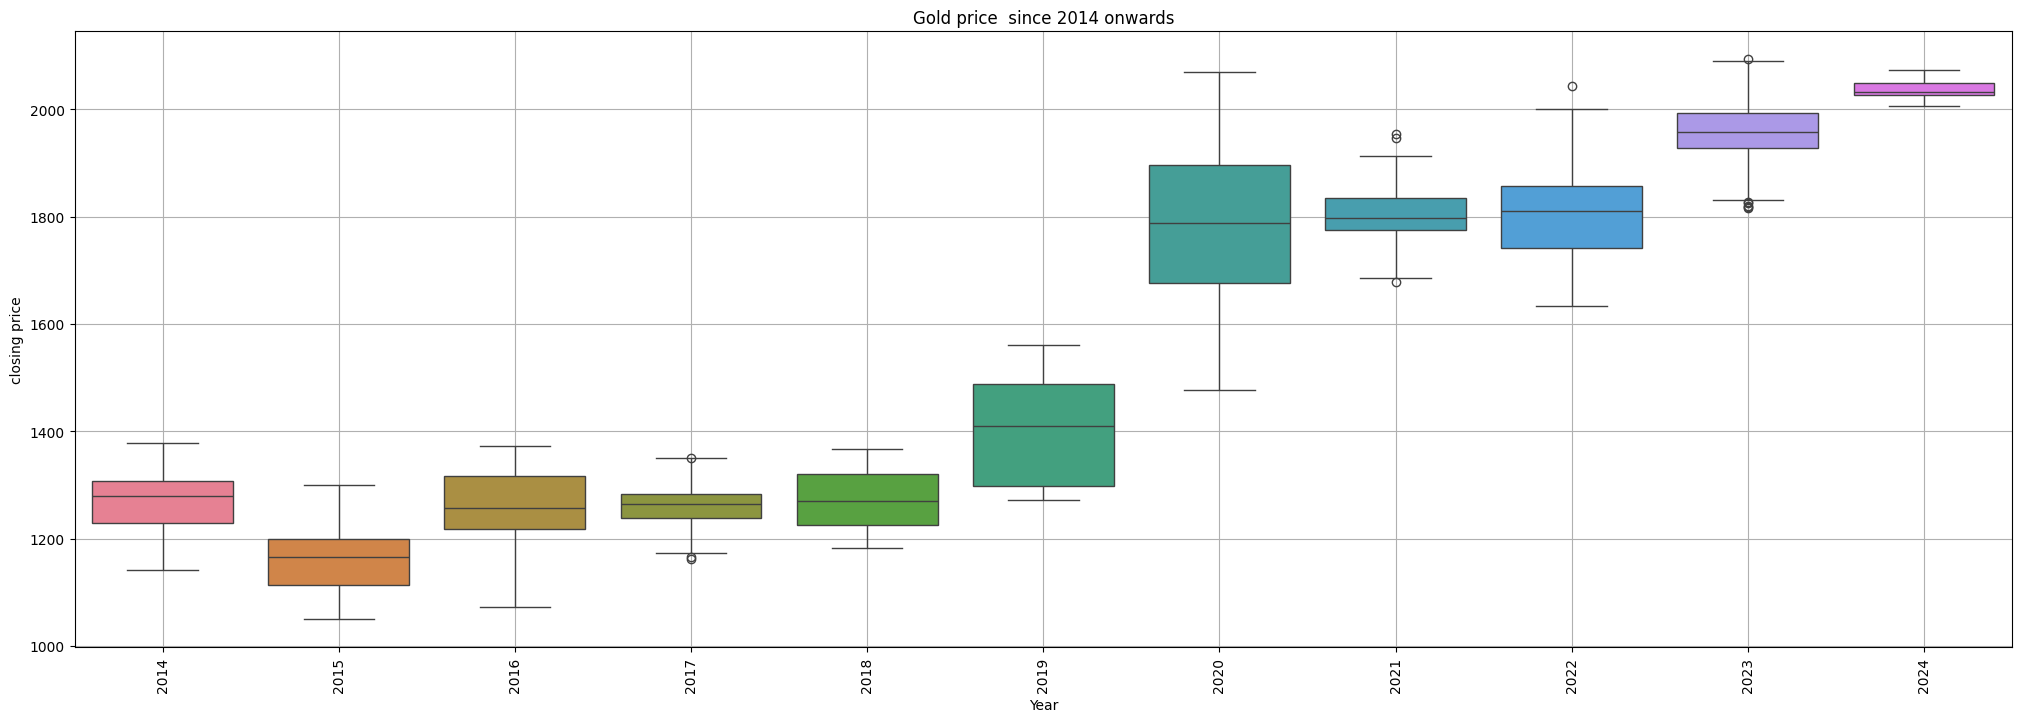

In [ ]:
custom_palette = sns.color_palette("husl", 12)
_, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x=df.index.year, y=df['Close'], ax=ax,palette=custom_palette)
plt.title("Gold price  since 2014 onwards")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.xticks(rotation=90)
plt.grid()
plt.show()

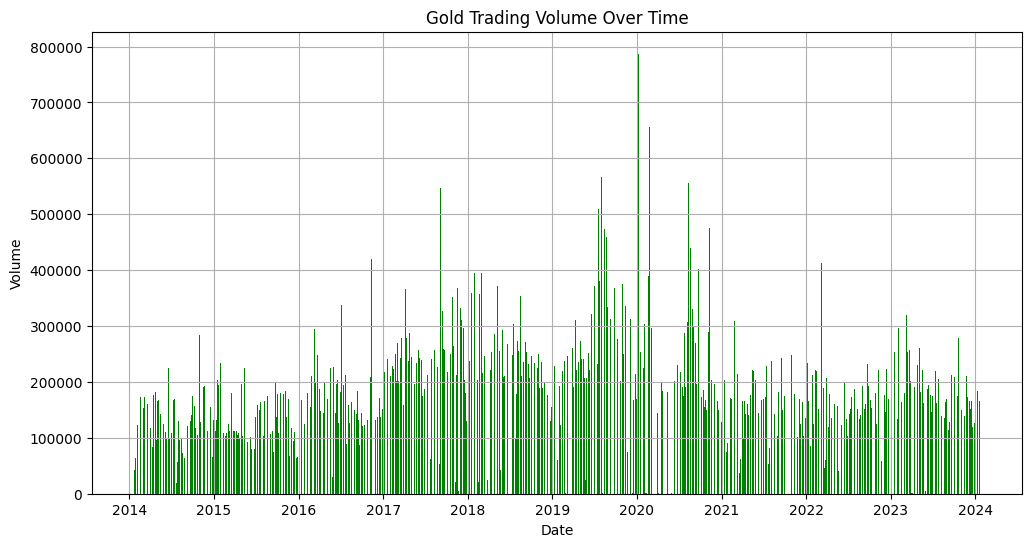

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['Volume'], color='green')
plt.title('Gold Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

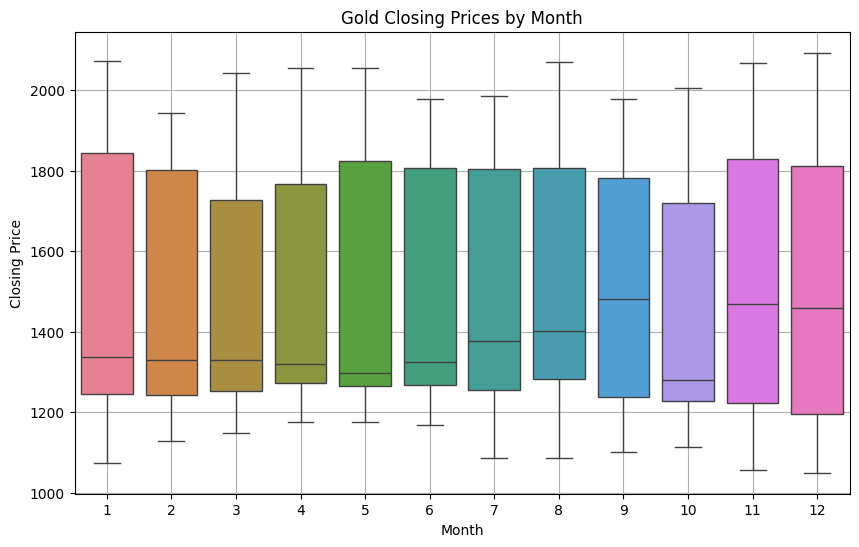

In [ ]:
df['Month'] = df.index.month
custom_palette = sns.color_palette("husl", 12)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=df,palette=custom_palette)
plt.title('Gold Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

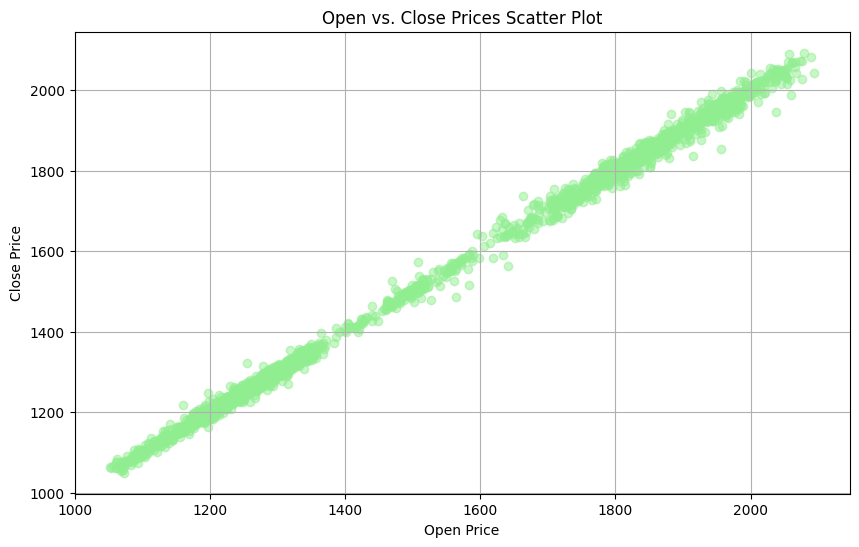

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Open'], df['Close'], color='lightgreen', alpha=0.5)
plt.title('Open vs. Close Prices Scatter Plot')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

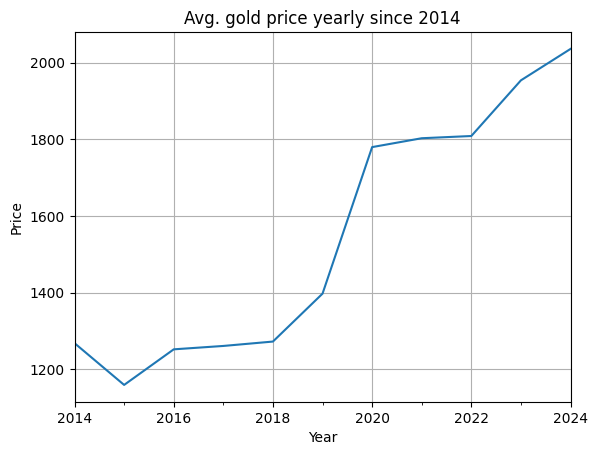

In [ ]:
df_yearly_sum=df1.resample('A').mean()
df_yearly_sum.plot();
plt.title('Avg. gold price yearly since 2014')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid();


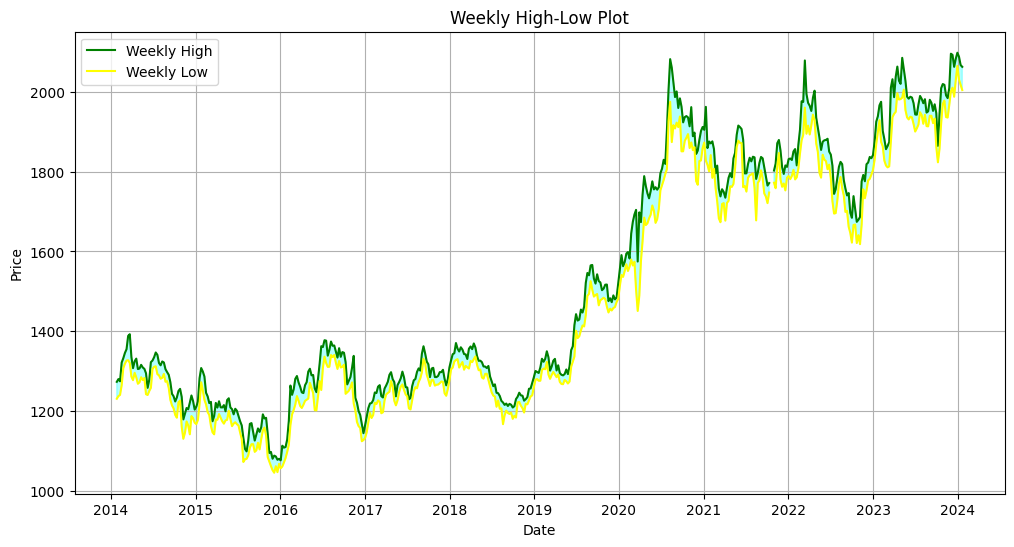

In [ ]:
plt.figure(figsize=(12, 6))
df_resampled = df.resample('W').agg({'High': 'max', 'Low': 'min'})
plt.plot(df_resampled.index, df_resampled['High'], label='Weekly High', color='green')
plt.plot(df_resampled.index, df_resampled['Low'], label='Weekly Low', color='yellow')
plt.fill_between(df_resampled.index, df_resampled['High'], df_resampled['Low'], color='cyan', alpha=0.3)
plt.title('Weekly High-Low Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


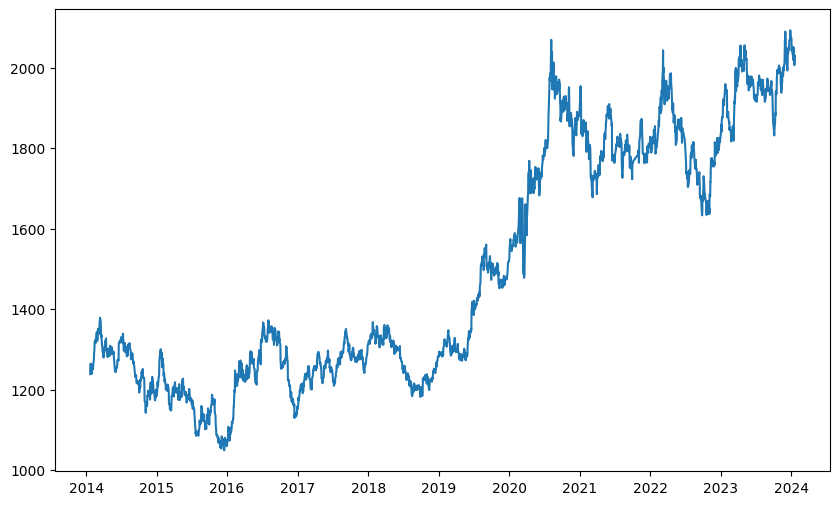

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10,6)})
plt.plot(df1)

In [ ]:
# Multiplicative Decomposition
mul_result = seasonal_decompose(df1, model='multiplicative',period=1)

# Additive Decomposition
add_result = seasonal_decompose(df1, model='additive',period=1)

Text(0.5, 0.98, '\nMultiplicative Decompose')

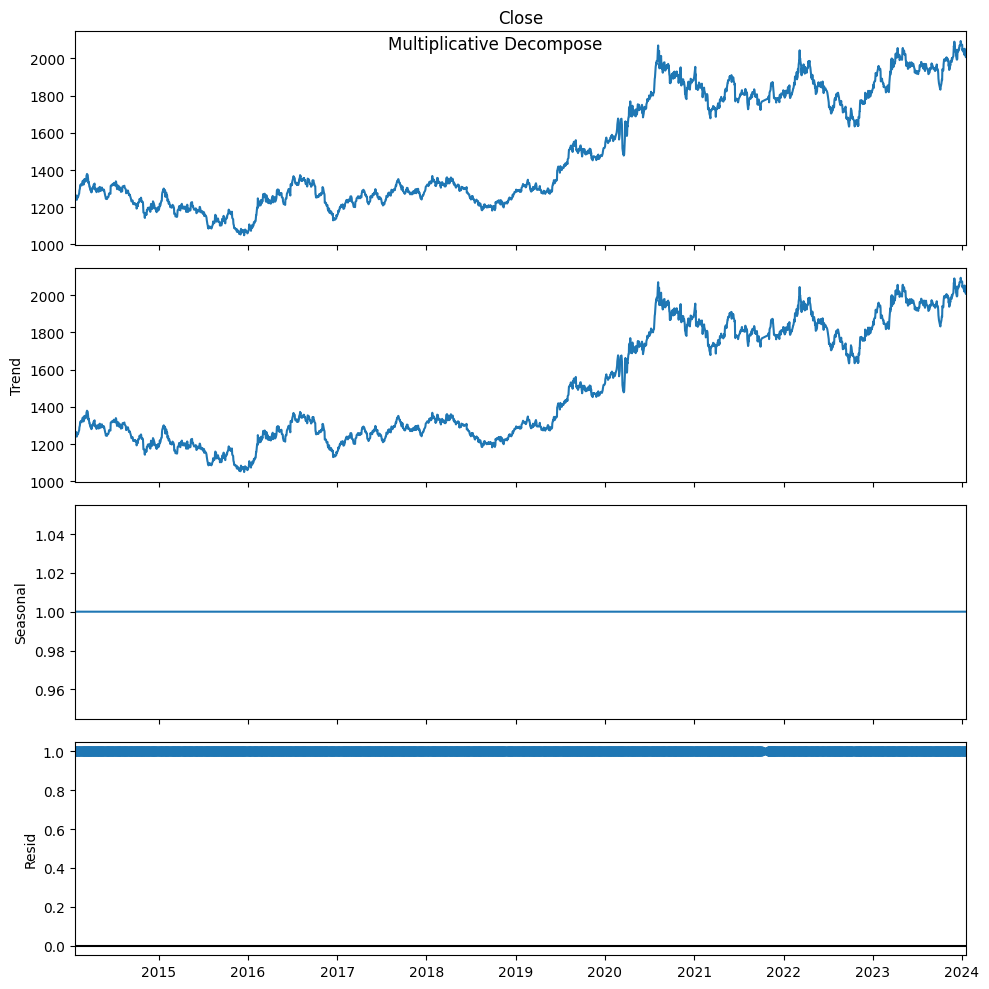

In [ ]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

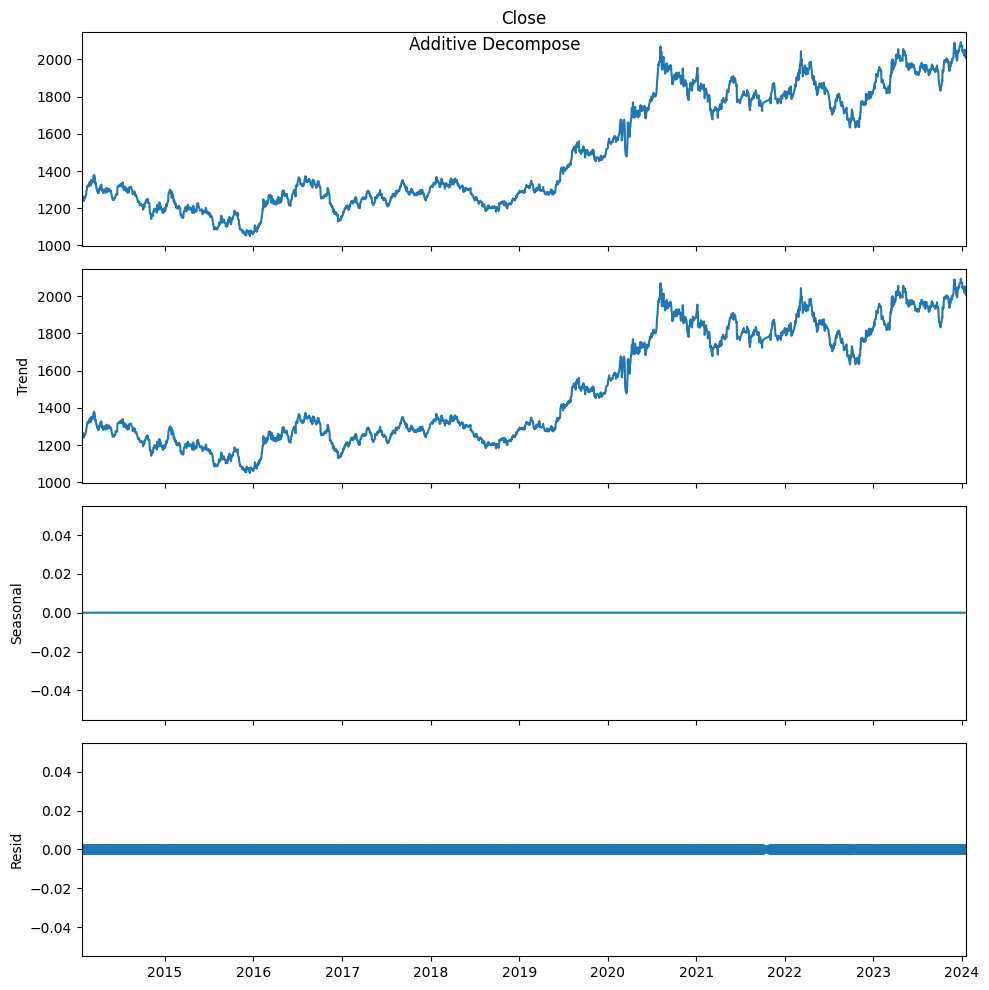

In [ ]:
add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)
plt.show()

In [ ]:
#Additive
new_df_add = pd.concat([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed], axis=1)
new_df_add.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_add.head(5)

,seasoanilty,trend,residual,actual_values
Date,,,,
2014-01-22,0.0,1238.6,0.0,1238.6
2014-01-23,0.0,1262.5,0.0,1262.5
2014-01-24,0.0,1264.5,0.0,1264.5
2014-01-27,0.0,1263.5,0.0,1263.5
2014-01-28,0.0,1250.5,0.0,1250.5


In [ ]:
#Multiplicative
new_df_mult = pd.concat([mul_result.seasonal, mul_result.trend, mul_result.resid, mul_result.observed], axis=1)
new_df_mult.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_mult.head(5)

,seasoanilty,trend,residual,actual_values
Date,,,,
2014-01-22,1.0,1238.6,1.0,1238.6
2014-01-23,1.0,1262.5,1.0,1262.5
2014-01-24,1.0,1264.5,1.0,1264.5
2014-01-27,1.0,1263.5,1.0,1263.5
2014-01-28,1.0,1250.5,1.0,1250.5


#Stationarity Check

In [ ]:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(df1.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.6413674258701233
p-value: 0.8613580932341661
Critial Values:
   1%, -3.432959008741782
Critial Values:
   5%, -2.862692648021296
Critial Values:
   10%, -2.567383598871881


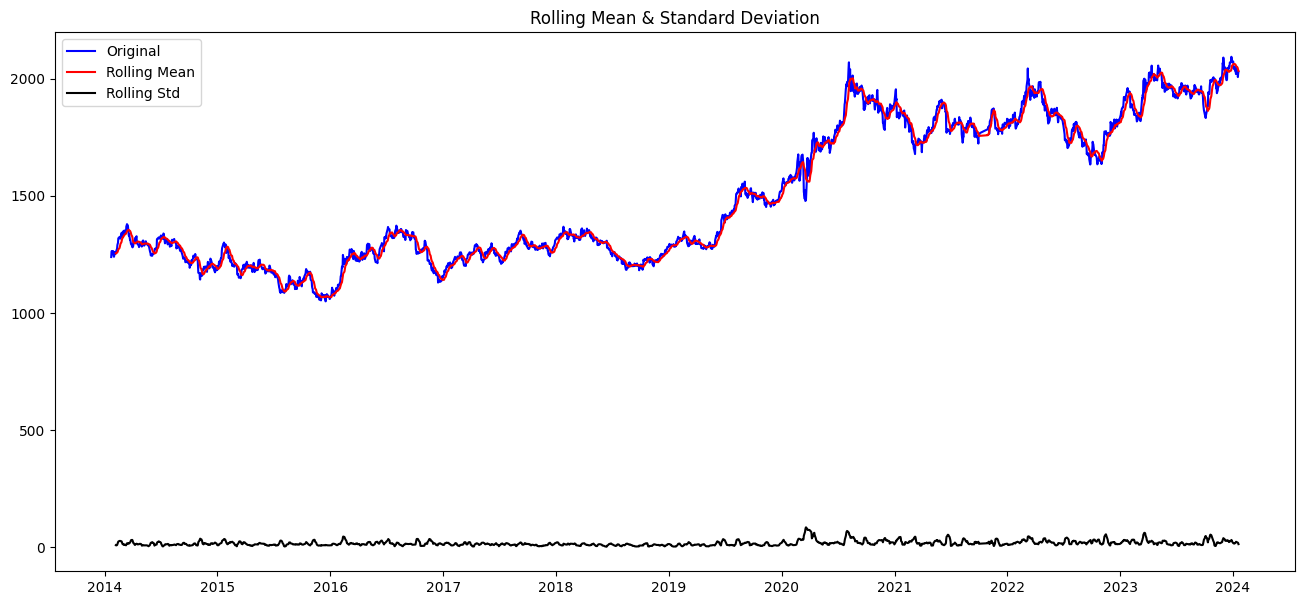

In [ ]:
#Determing rolling statistics
rolLmean = df1.rolling(12).mean()
rolLstd = df1.rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df1, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Making the dataset Stationary


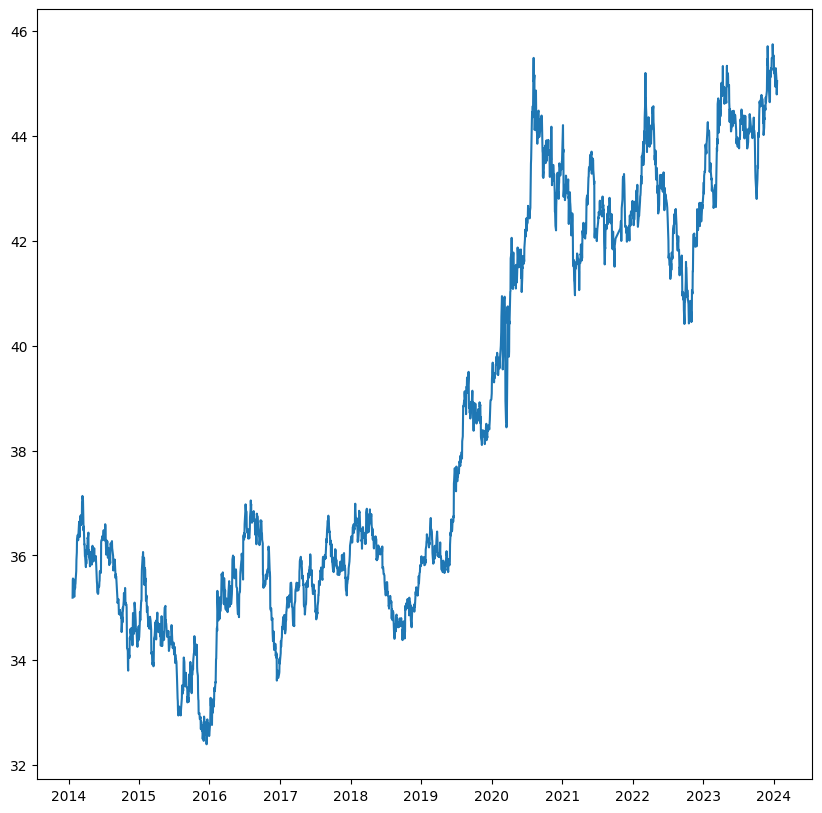

In [ ]:
# Calculate the square root
adj_sqrt = np.sqrt(df1)
plt.plot(adj_sqrt)

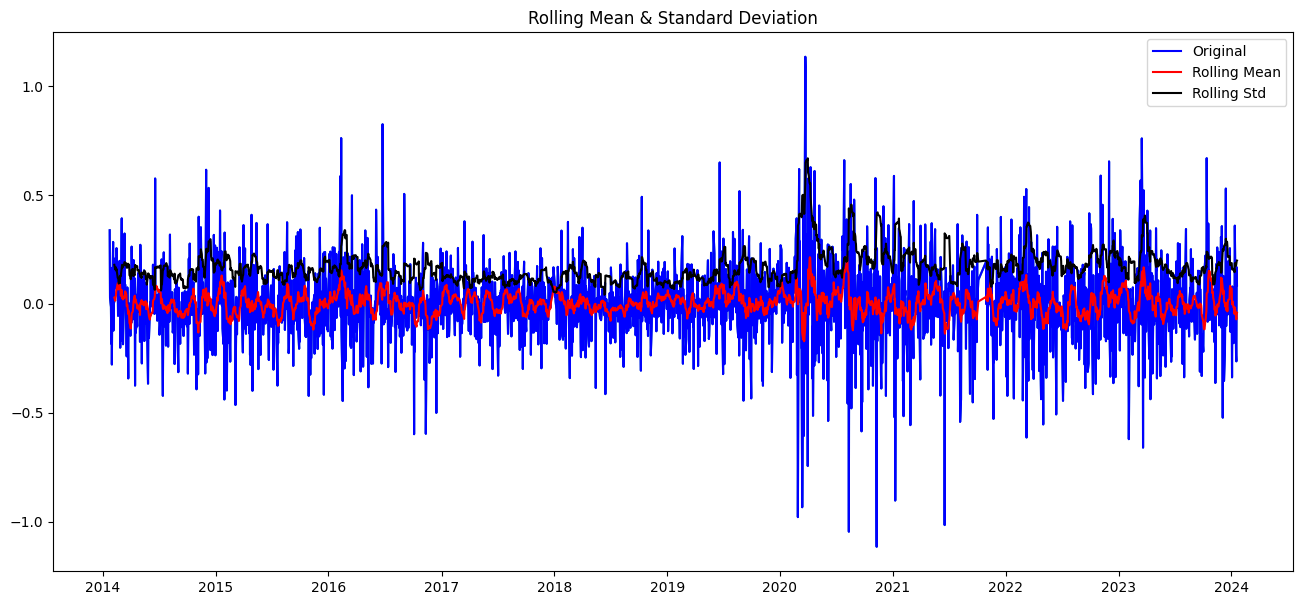

In [ ]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
adj_sqrt_diff = adj_sqrt - adj_sqrt.shift()
plt.plot(adj_sqrt_diff)

#Determing rolling statistics
rolLmean =adj_sqrt_diff.rolling(12).mean()
rolLstd = adj_sqrt_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(adj_sqrt_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)



In [ ]:
df1.sort_index(inplace= True)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(adj_sqrt_diff, nlags=20)
lag_pacf = pacf(adj_sqrt_diff, nlags=20)

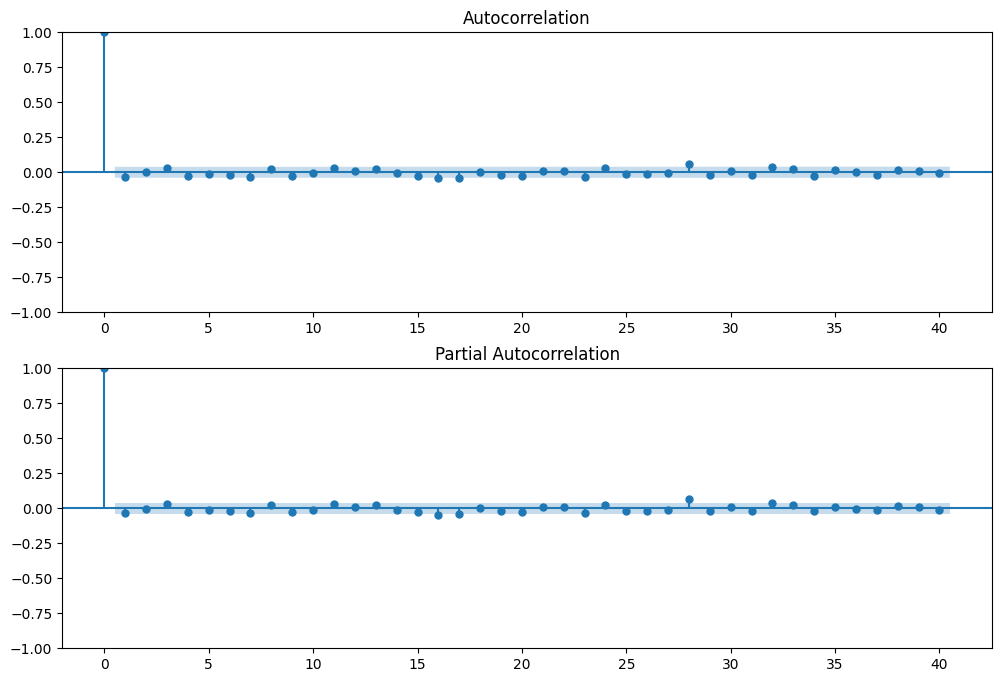

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(adj_sqrt_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(adj_sqrt_diff.dropna(),lags=40,ax=ax2)

#Model Implementation

In [ ]:
type(adj_sqrt_diff)

pandas.core.series.Series

In [ ]:
adj_sqrt_diff = adj_sqrt_diff[~adj_sqrt_diff.isnull()]


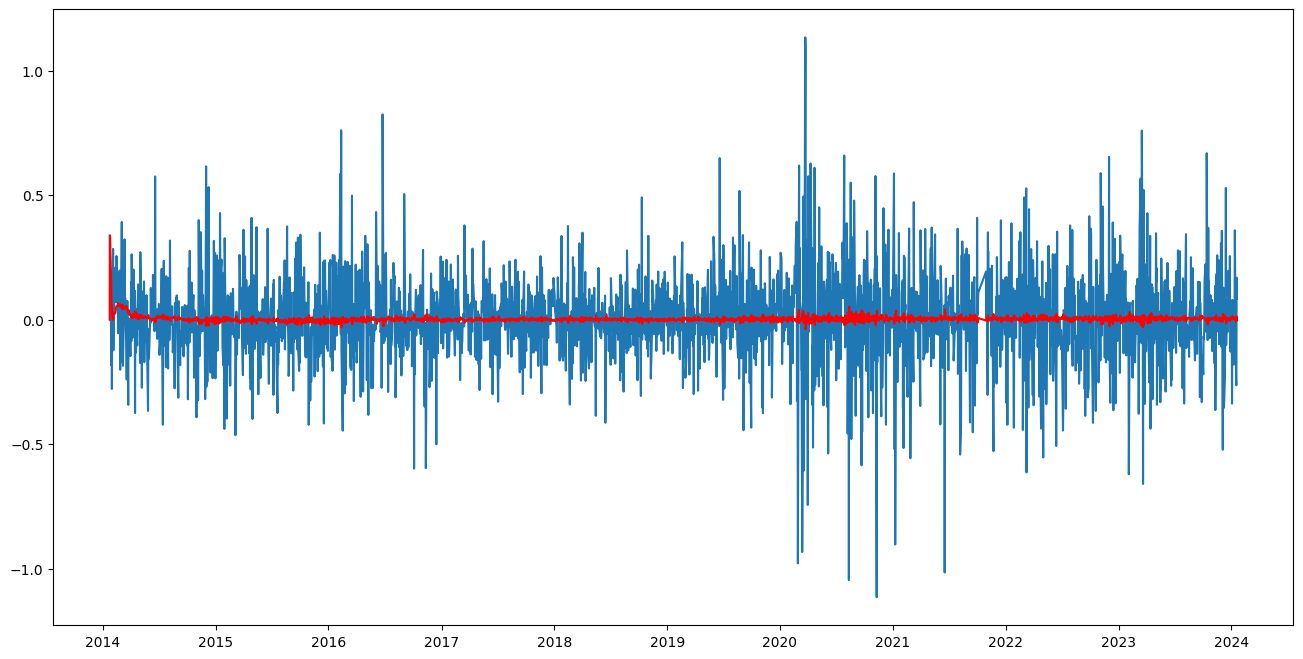

In [ ]:
plt.figure(figsize=(16,8))
model = ARIMA(adj_sqrt_diff, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(adj_sqrt_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [ ]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

Date
2014-01-23    0.000000
2014-01-24    0.337927
2014-01-27    0.189044
2014-01-28    0.119797
2014-01-29    0.050405
dtype: float64


In [ ]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

Date
2014-01-23    0.000000
2014-01-24    0.337927
2014-01-27    0.526970
2014-01-28    0.646768
2014-01-29    0.697172
dtype: float64


In [ ]:
ARIMA_sqrt_prediction = pd.Series(adj_sqrt.iloc[0], index=adj_sqrt.index)
ARIMA_sqrt_prediction = ARIMA_sqrt_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_sqrt_prediction.head()

Date
2014-01-22    35.193749
2014-01-23    35.193749
2014-01-24    35.531676
2014-01-27    35.720720
2014-01-28    35.840517
dtype: float64

Text(0.5, 1.0, 'RMSE: 224.7471')

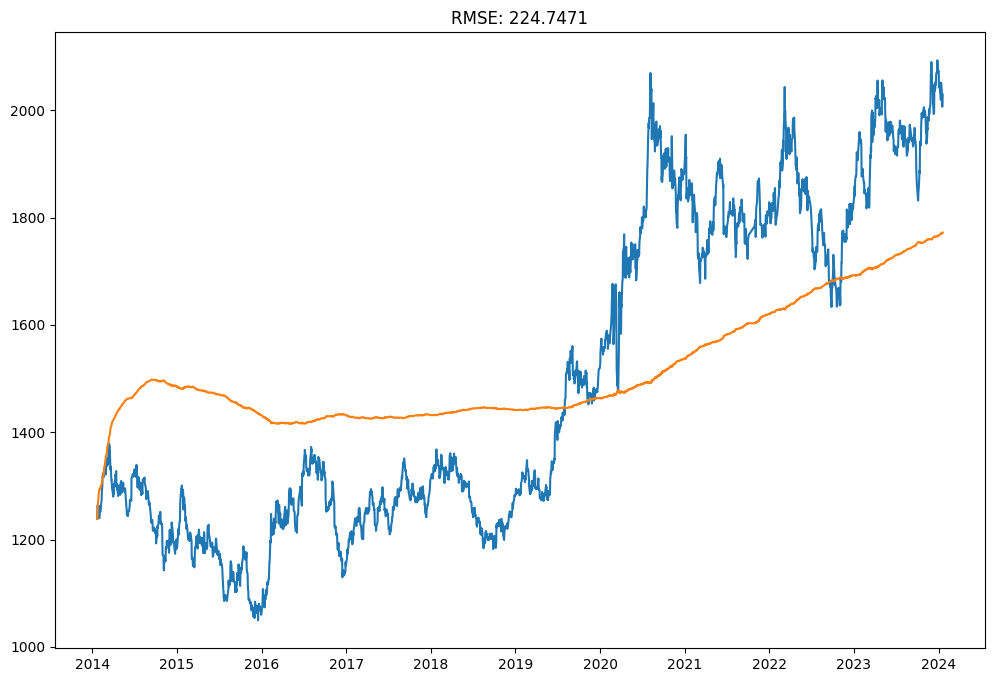

In [ ]:
plt.figure(figsize=(12,8))
predictions_ARIMA = ARIMA_sqrt_prediction **2
plt.plot(df1)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df1)**2)/len(df1)))

In [ ]:
results_ARIMA.predict(10,20)

Date
2014-02-06    0.024033
2014-02-07    0.022595
2014-02-10    0.026786
2014-02-11    0.032741
2014-02-12    0.045890
2014-02-13    0.050801
2014-02-14    0.053398
2014-02-18    0.057539
2014-02-19    0.066784
2014-02-20    0.062813
2014-02-21    0.058863
Name: predicted_mean, dtype: float64

In [ ]:
!pip install pmdarima
import pmdarima as pm
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                              start_p=3,
                              start_q=3,
                              max_p=5,
                              max_q=5,
                              test="adf",
                              seasonal=True,
                              trace=True)
    return automodel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
arimamodel(adj_sqrt)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1419.232, Time=4.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1417.327, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1418.574, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1418.580, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1418.163, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1417.316, Time=7.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.73 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1411.731, Time=10.11 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1414.249, Time=4.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1422.849, Time=3.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1415.492, Time=1.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1414.586, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1416.579, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1415.913, Time=3.58 sec
 ARIMA(3,1,1)(0,0,0)[0] 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#Machine learning Model

In [ ]:
train = df[df.index.year <= 2022][['Close']]  # Selecting 'Close' as a DataFrame
test = df[df.index.year > 2022][['Close']]    # Selecting 'Close' as a DataFrame

print("Training Set Shape:", train.shape)
print("Testing Set Shape:", test.shape)

Training Set Shape: (2248, 1)
Testing Set Shape: (263, 1)


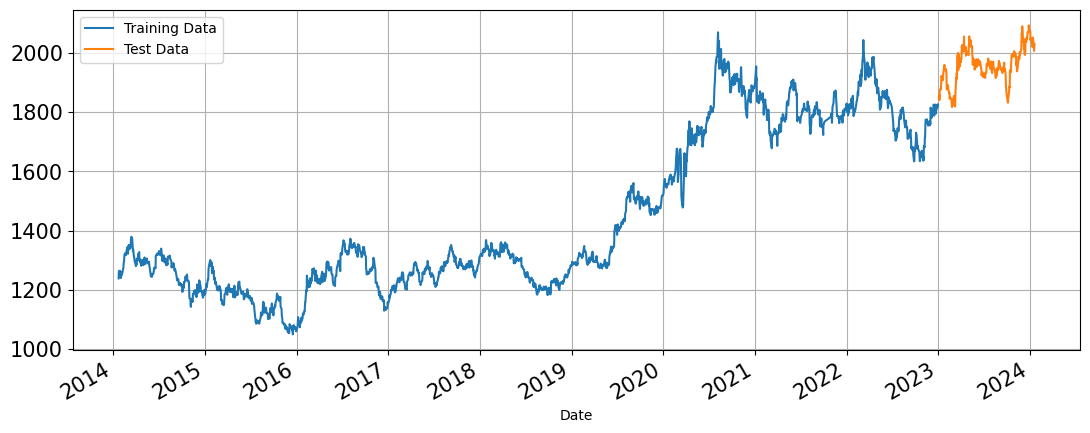

In [ ]:
train["Close"].plot(figsize=(13,5), fontsize =15)
test["Close"].plot(figsize=(13,5), fontsize =15)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [ ]:
train_time=[i+1 for i in range(len(train))]
test_time=[i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(2248, 263)

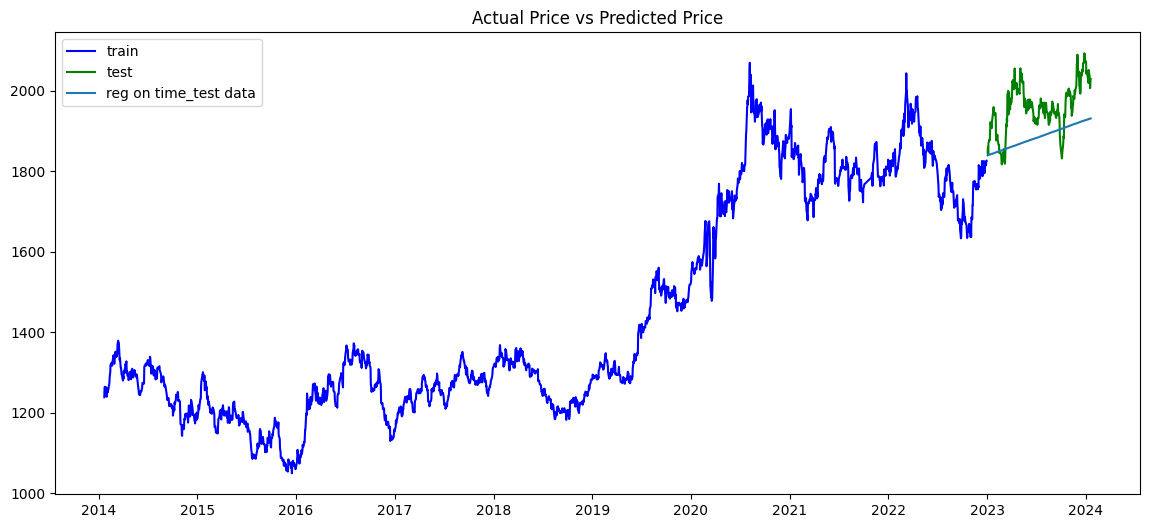

In [ ]:
LR_train = train.copy()
LR_train['time'] = train_time

LR_test = test.copy()
LR_test['time'] = test_time

# Fit a linear regression model
linear_regression = LinearRegression()
linear_regression.fit(LR_train[['time']], LR_train['Close'].values)

# Make predictions using the linear regression model
test_predictions_model1 = linear_regression.predict(LR_test[['time']].values)
LR_test['forecast'] = test_predictions_model1

# Plot the actual and predicted prices
plt.figure(figsize=(14,6))
plt.plot(train['Close'], color='blue', label='train')
plt.plot(test['Close'], color='green', label='test')
plt.plot(LR_test['forecast'], label='reg on time_test data')
plt.title('Actual Price vs Predicted Price')
plt.legend(loc='best')
plt.show()

#Trading Strategy Development

In [ ]:
def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

In [ ]:
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70

    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)

        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)

        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)


    def next(self):
        price = self.data.Close[-1]

        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):

            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)

        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()

In [ ]:
duplicate_index = df.index[df.index.duplicated()]
print(duplicate_index)

DatetimeIndex(['2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03',
               '2021-11-04', '2021-11-05', '2021-11-08', '2021-11-09',
               '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
df = df[~df.index.duplicated()]
#df.reset_index(drop=True, inplace=True)
df

,Close,Volume,Open,High,Low
Date,,,,,
2014-01-22,1238.6,80262.0,1240.5,1243.5,1235.5
2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
...,...,...,...,...,...
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6


In [ ]:
from backtesting.test import GOOG


backtest = Backtest(df, System, cash=10000, commission=.002)
backtest.run()

Start                     2014-01-22 00:00:00
End                       2024-01-19 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                    0.320899
Equity Final [$]                    9768.9784
Equity Peak [$]                    10032.9784
Return [%]                          -2.310216
Buy & Hold Return [%]               63.838204
Return (Ann.) [%]                   -0.235984
Volatility (Ann.) [%]                0.990342
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.241311
Avg. Drawdown [%]                   -2.391763
Max. Drawdown Duration     1598 days 00:00:00
Avg. Drawdown Duration      803 days 00:00:00
# Trades                                    1
Win Rate [%]                              0.0
Best Trade [%]                      -2.476269
Worst Trade [%]                     -2.476269
Avg. Trade [%]                    

In [ ]:
%%time

backtest.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10))

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 140 ms, sys: 37.2 ms, total: 177 ms
Wall time: 9.65 s


Start                     2014-01-22 00:00:00
End                       2024-01-19 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                    2.968311
Equity Final [$]                    9994.6556
Equity Peak [$]                    11187.3036
Return [%]                          -0.053444
Buy & Hold Return [%]               63.838204
Return (Ann.) [%]                   -0.005404
Volatility (Ann.) [%]                3.033085
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -10.660728
Avg. Drawdown [%]                   -2.045186
Max. Drawdown Duration     1425 days 00:00:00
Avg. Drawdown Duration      150 days 00:00:00
# Trades                                    3
Win Rate [%]                        33.333333
Best Trade [%]                       6.665721
Worst Trade [%]                     -6.212614
Avg. Trade [%]                    

In [ ]:
backtest.plot()

GridPlot(id='p1437', ...)

#Investigating various impact of market events on gold prices.


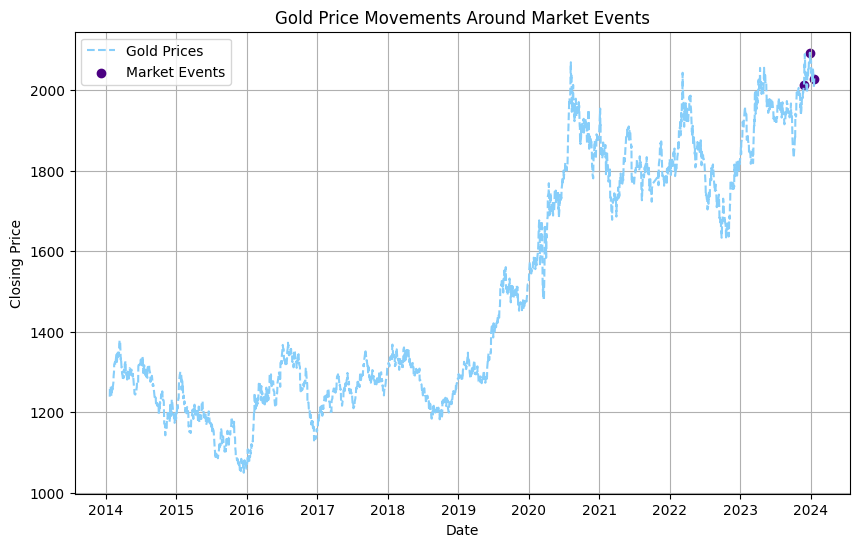

In [ ]:
#indicating market events such as rising gold price high in december 2023
event_dates = ['2023-11-27','2023-12-27','2024-01-19']  # Example market event dates
event_prices = [2012,2093,2029]  # Example: Closing prices around the events

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'],  color='lightskyblue', linestyle='--', label='Gold Prices')
plt.scatter(event_dates, event_prices, color='indigo', label='Market Events')
plt.title('Gold Price Movements Around Market Events')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


#market sentiment and its influence on short-term and long-term price movements

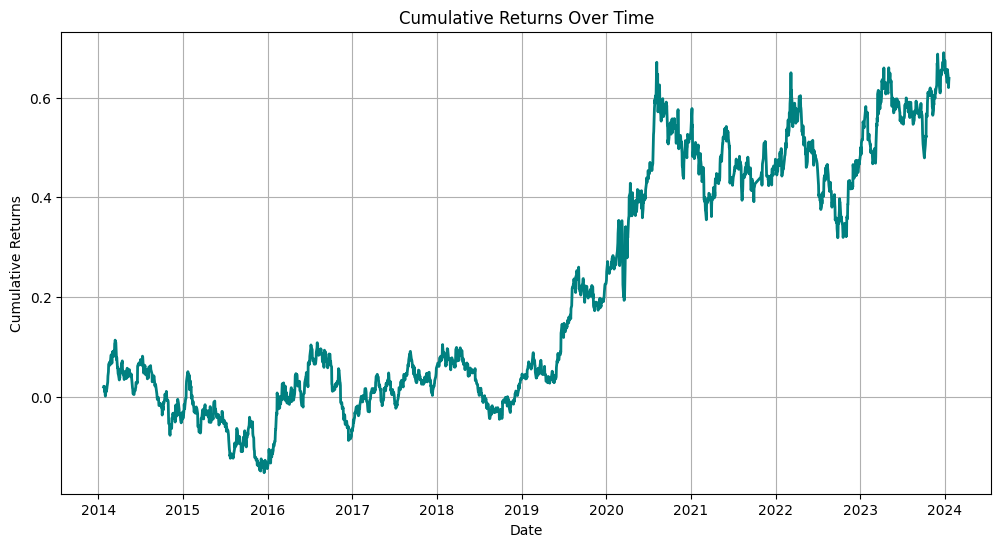

In [ ]:
df['Daily_Returns'] = df['Close'].pct_change()
# Calculate the cumulative returns
df['Cumulative_Returns'] = (1 + df['Daily_Returns']).cumprod() - 1
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Returns'], color='teal', linestyle='-', linewidth=2)
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

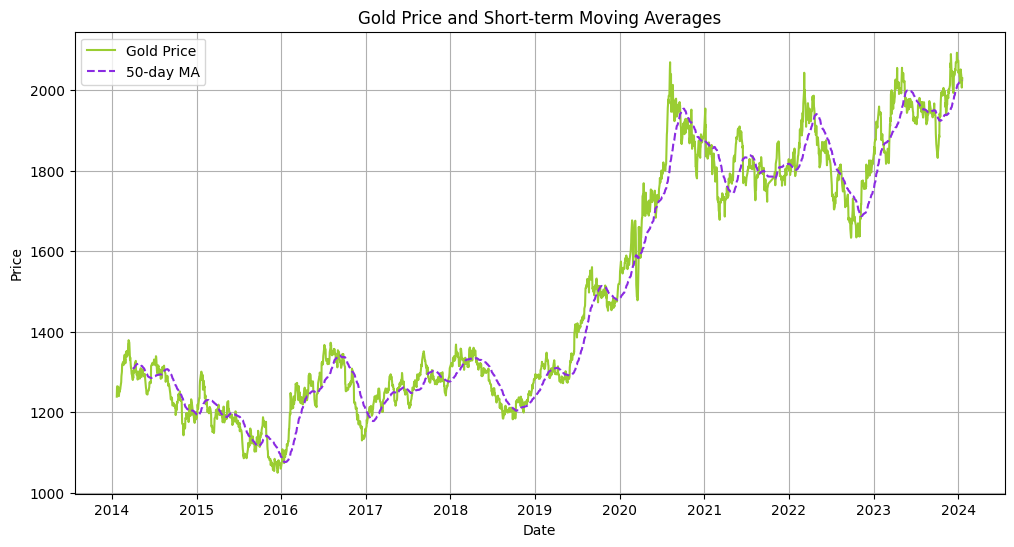

Short-term correlation between price change and volume change: -0.06345616342538564


In [ ]:
#daily price changes and trading volume changes
df['Price Change'] = df['Close'] - df['Open']
df['Volume Change'] = df['Volume'].diff()

# Analyze Short-term Price Movements
# Calculate correlation between price changes and volume changes
short_term_correlation = df['Price Change'].corr(df['Volume Change'])
# Calculate moving averages of closing prices for short-term and long-term trends
short_term_ma = df['Close'].rolling(window=50).mean()  # 30-day moving average
long_term_ma = df['Close'].rolling(window=200).mean()   # 200-day moving average

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'],color='yellowgreen', label='Gold Price')
plt.plot(df.index, short_term_ma,color='blueviolet',label='50-day MA', linestyle='--')
#plt.plot(df.index, long_term_ma, label='90-day MA', linestyle='--')
plt.title('Gold Price and Short-term Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(f"Short-term correlation between price change and volume change: {short_term_correlation}")


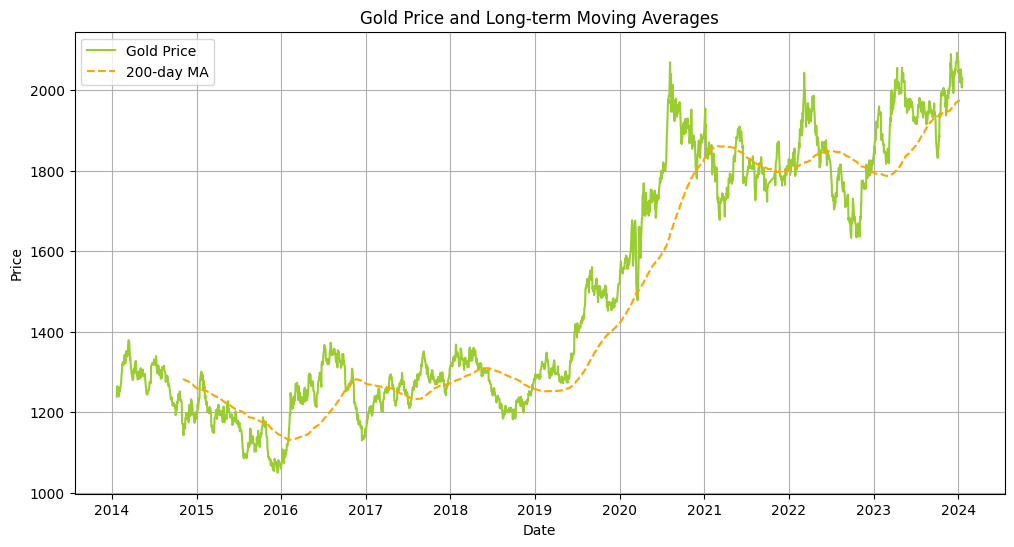

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'],color='yellowgreen', label='Gold Price')
#plt.plot(df.index, short_term_ma,color='blueviolet',label='50-day MA', linestyle='--')
plt.plot(df.index, long_term_ma, color='orange',label='200-day MA', linestyle='--')
plt.title('Gold Price and Long-term Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#Statistical Analysis

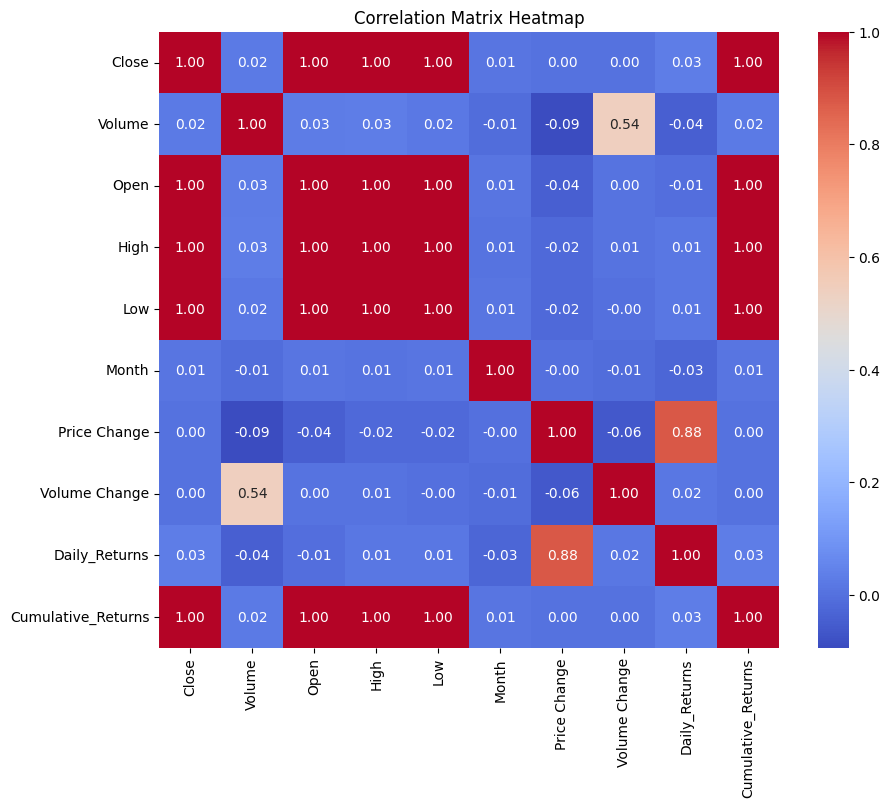

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


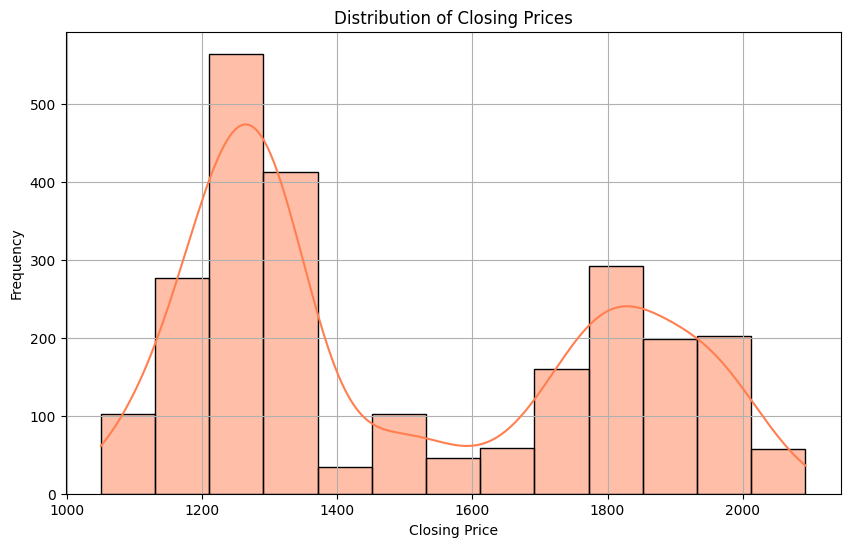

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, color='coral')
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


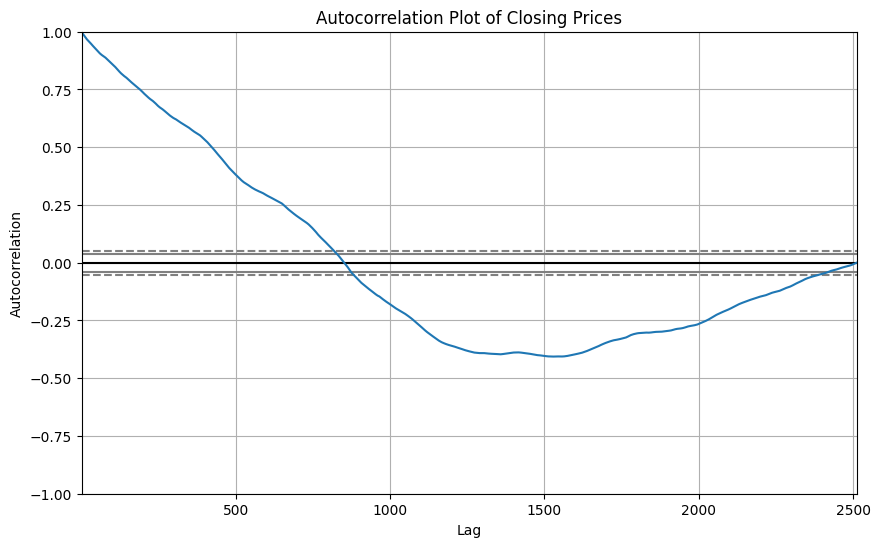

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(df['Open'])
plt.title('Autocorrelation Plot of Closing Prices')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

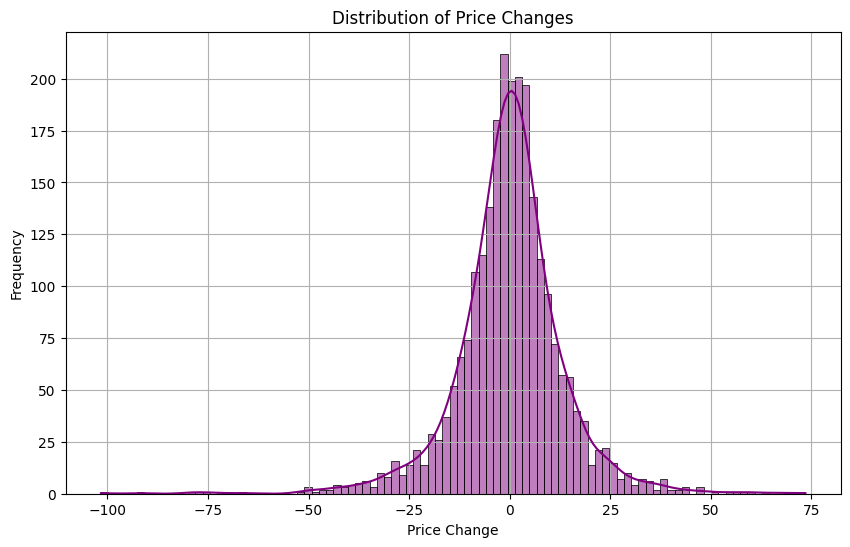

In [ ]:
price_change = df['Close'] - df['Open']
plt.figure(figsize=(10, 6))
sns.histplot(price_change, kde=True, color='purple')
plt.title('Distribution of Price Changes')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()